In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats
import tensorflow as tf
import math
import random

%matplotlib inline
plt.style.use('ggplot')

In [2]:
normalization_coef = 9
batch_size = 10
kernel_size = 30
depth = 20
num_hidden = 100
num_channels = 2

learning_rate = 0.0001
training_epochs = 3

filter_value = 20

In [3]:
def convolve1d(signal, length):
    ir = np.ones(length)/length
    #return np.convolve(y, ir, mode='same')
    
    output = np.zeros_like(signal)

    for i in range(len(signal)):
        for j in range(len(ir)):
            if i - j < 0: continue
            output[i] += signal[i - j] * ir[j]
            
    return output

def filterRecord(record, filter_value):
    x = convolve1d(record[:,0], filter_value)
    y = convolve1d(record[:,1], filter_value)
    return np.dstack([x,y,z])[0]


def readFileData(file):
    column_names = ['timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file, header = None, names = column_names)
    
    x = data["x-axis"]
    y = data["y-axis"]
    z = data["z-axis"]
    
    return np.dstack([x,y,z])[0]

def readData(directory):
    records = []
    labels = np.empty((0))
    
    allFiles = glob.glob(directory + "/*.log")
    for file in allFiles:
        fileName = os.path.basename(file)
        (name, ext) = os.path.splitext(fileName)
        parts = name.split("_")
        if (len(parts) == 2):
            label = parts[0]
            fileData = readFileData(file)
            
            records.append(fileData)
            labels = np.append(labels, label)
            
    return (records, labels)

def getRecordsMaxLength(records):
    maxLen = 0
    for record in records:
        if (len(record) > maxLen):
            maxLen = len(record)
        
    return maxLen

def extendRecordsLen(records, length):
    ret = np.empty((0, length, 2))
    
    for index in range(len(records)):
        record = records[index]
        if (len(record) < length):
            record = np.pad(record, ((0, length - len(record)), (0,0)), mode='constant', constant_values=0)
            
        if filter_value != 0: 
            record = filterRecord(record, filter_value)
            
        ret = np.append(ret, [record], axis=0)
    
    return ret

def augmentRecord(record, shift):
    e = np.empty_like(record)
    if shift >= 0:
        e[:shift] = 0
        e[shift:] = record[:-shift]
    else:
        e[shift:] = 0
        e[:shift] = record[-shift:]
    return e

def augmentData(records, labels, length):
    aug_records = np.empty((0, length, 2))
    aug_labels = np.empty((0))

    for index in range(len(records)):
        record = records[index]
        label = labels[index]
        
        aug_records = np.append(aug_records, [record], axis=0)
        aug_labels = np.append(aug_labels, label)
        
        shift = 3 # 3..21 step 3
        while shift <= 21:
            aug_records = np.append(aug_records, [augmentRecord(record, shift)], axis=0)
            aug_labels = np.append(aug_labels, label)
            
            aug_records = np.append(aug_records, [augmentRecord(record, -shift)], axis=0)
            aug_labels = np.append(aug_labels, label)

            shift += 3

    return (aug_records, aug_labels)
        

def normalizeRecords(records):
    return records / normalization_coef

def plotRecord(record, label):
    plt.plot(record)
    plt.ylabel(label)
    plt.show()
    
def plotRecords(record1, record2):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(record1)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(record2)

    plt.show()

In [4]:
(records, labels) = readData("data")
rec_len = getRecordsMaxLength(records)
print("Record length is %d" % rec_len)

records = extendRecordsLen(records, rec_len)
records = normalizeRecords(records)
(records, labels) = augmentData(records, labels, rec_len)

labelsBin = np.asarray(pd.get_dummies(labels), dtype = np.int8)

print("Samples: %d" % len(records))

Record length is 128
Samples: 11640


In [13]:

def find_label_id(x):
    i = 0
    for label in labels:
        if x == label:
            print(labelsBin[i])
            return
        i += 1

find_label_id('Red')
find_label_id('Green')
find_label_id('Blue')
find_label_id('Teal')


[0 0 1 0]
[0 1 0 0]
[1 0 0 0]
[0 0 0 1]


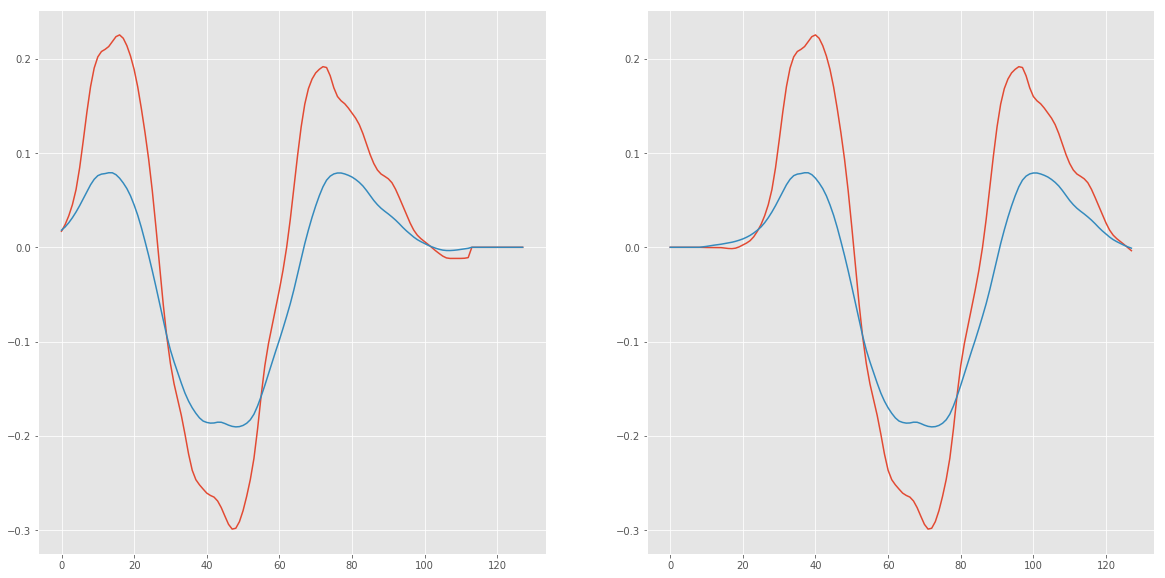

In [14]:
plotRecords(records[10], records[5])

In [15]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [16]:
train_test_split = np.random.rand(len(records)) < 0.70
train_x = records[train_test_split]
train_y = labelsBin[train_test_split]
test_x = records[~train_test_split]
test_y = labelsBin[~train_test_split]


In [17]:
num_labels = len(set(labels))
total_batches = train_x.shape[0] // batch_size

In [18]:
X = tf.placeholder(tf.float32, shape=[None, rec_len, num_channels], name="x_input")
X_reshaped = tf.reshape(X, [-1, 1, rec_len, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])

c = apply_depthwise_conv(X_reshaped, kernel_size, num_channels, depth)
p = apply_max_pool(c, 20, 2)
c = apply_depthwise_conv(p, 6, depth*num_channels, depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1), f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases, name="labels_output")

In [19]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
cost_history = np.empty(shape=[1],dtype=float)

saver = tf.train.Saver()

with tf.Session() as session:
    #tf.global_variables_initializer().run()
    session.run(tf.global_variables_initializer())
    # save the graph
    tf.train.write_graph(session.graph_def, '.', 'session.pb', False)
    
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            print(batch_x, batch_y)
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print ("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print ("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))
    saver.save(session, './session.ckpt')

[[[-0.00012996  0.00047955]
  [-0.00021436  0.00096929]
  [-0.00024517  0.00160777]
  ..., 
  [-0.01179917 -0.00222159]
  [-0.01160899 -0.0016542 ]
  [-0.01095286 -0.00108539]]

 [[-0.00026671  0.00221652]
  [-0.00027824  0.00269772]
  [-0.00036925  0.00326211]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00656292 -0.00212088]
  [-0.00935847 -0.00299511]
  [-0.01126588 -0.00340958]]

 ..., 
 [[ 0.00446012  0.0106073 ]
  [ 0.0070311   0.01265292]
  [ 0.01118978  0.01518207]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03480449  0.01739013]
  [ 0.02584084  0.01416997]
  [ 0.01825467  0.01084047]]

 [[ 0.01701476  0.0181314 ]
  [ 0.02411826  0.02159197]
  [ 0.03341072  0.02605018]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00870813  0.00059464]
  [-0.00943567 -0.0002284 ]
  [-0.00840199 -0.00030768]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00378326  0.00018447]
  [-0.00315763  0.00066978]
  [-0.00172042  0.00116394]]

 [[-0.00068109  0.0003717 ]
  [-0.00162648  0.00044609]
  [-0.00239582  0.00050258]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01122204  0.01019516]
  [ 0.00945393  0.00782219]
  [ 0.00860127  0.00589877]]

 [[ 0.00083951  0.00430791]
  [ 0.00114892  0.00503884]
  [ 0.00175258  0.00568686]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.02052

[[[ 0.10719333  0.08476667]
  [ 0.11943667  0.10295056]
  [ 0.12763611  0.12077667]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.32129944  0.22582611]
  [-0.32465222  0.21152278]
  [-0.32118556  0.19514833]]

 [[ 0.134045    0.13820444]
  [ 0.13937944  0.15489444]
  [ 0.14643167  0.17179778]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02005944  0.27664778]
  [-0.05456333  0.28307722]
  [-0.08867222  0.28737333]]

 [[ 0.06479     0.36727333]
  [ 0.01526444  0.37713222]
  [-0.03730778  0.38401167]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.31763

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.08089889 -0.03607222]
  [ 0.08258611 -0.02522944]
  [ 0.07293222 -0.01879556]]

 [[-0.01197111 -0.01844556]
  [-0.01589    -0.02049111]
  [-0.021045   -0.02254222]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.043495   -0.09412278]
  [ 0.05426056 -0.07276944]
  [ 0.06800722 -0.05171667]]

 ..., 
 [[-0.02972111  0.28929277]
  [-0.06116722  0.31779333]
  [-0.10016667  0.34223444]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.18395389  0.08885   ]
  [ 0.24004778  0.11132611]
  [ 0.29620111  0.14144333]]

 [[-0.14582333  0.36007277]
  [-0.19981222  0.36960055]
  [-0.25948444  0.36966499]
  ..., 
  [ 0.     

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  5.99436111e-01   5.34327778e-02]
  [  6.40473333e-01   8.97538889e-02]
  [  6.74910000e-01   1.29713333e-01]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  4.53070556e-01  -2.86333333e-02]
  [  5.03905000e-01  -5.94277778e-03]
  [  5.53433889e-01   2.14077778e-02]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -5.13756111e-03   3.42216111e-03]
  [ -2.03038889e-03   4.05105556e-03]
  [  7.65716667e-04   4.47113333e-03]]

 ..., 
 [[ -5.36199722e-02  -1.04486167e-02]
  [ -6.86627778e-02  -1.46173722e-02]
  [ -8.80216111e-02  -2.24074889e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01355239  0.00814952]
  [ 0.01442372  0.00809187]
  [ 0.01609538  0.00880879]]

 [[-0.18940846 -0.08385631]
  [-0.22906886 -0.10474986]
  [-0.26384271 -0.12540586]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.04843111  0.08491722]
  [-0.01009389  0.06496333]
  [ 0.03048444  0.04737667]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.39547833  0.25349222]
  [-0.38373833  0.23597389]
  [-0.35906667  0.21743278]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.357685    0.28668833]
  [-0.38186056  0.27934222]
  [-0.39513     0.26811056]]

 [[ 0.57329166  0.36925056]
  [ 0.59914888  0.42142111]
  [ 0.6165861   0.47397333]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00804542  0.01120889]
  [ 0.00475144  0.00826691]
  [ 0.00298229  0.00538242]]

 [[-0.00404152  0.00489165]
  [-0.00574262  0.00508506]
  [-0.01080449  0.00467019]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01866133  0.01863068]
  [ 0.01588397  0.01658694]
  [ 0.01207326  0.01406879]]

 ..., 
 [[-0.00975167  0.002895  ]
  [-0.01082389  0.00224111]
  [-0.01153222  0.00167333]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03829389 -0.15341556]
  [-0.03293833 -0.15639667]
  [-0.02821944 -0.15920056]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.05547

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.0065901  -0.00444896]
  [-0.00635776 -0.00270374]
  [-0.00520592 -0.00027037]]

 [[ 0.01019406  0.00709807]
  [ 0.0143918   0.00986635]
  [ 0.02269544  0.01427337]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00930693 -0.00747149]
  [-0.00783263 -0.00625144]
  [-0.00691223 -0.00539591]]

 ..., 
 [[ 0.04822722  0.020565  ]
  [ 0.06394167  0.02933444]
  [ 0.08007833  0.03985944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.09573667  0.05175944]
  [ 0.11027833  0.06461889]
  [ 0.12503222  0.07796333]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.14134278  0.09215944]
  [ 0.15796056  0.10831778]
  [ 0.17217889  0.12694833]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00693556 -0.01729111]
  [-0.010015   -0.01886167]
  [-0.01419611 -0.022125  ]]

 [[-0.02479889 -0.07899833]
  [-0.03143    -0.09048111]
  [-0.03433278 -0.10207333]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00736722 -0.03168944]
  [ 0.00229389 -0.02635667]
  [-0.00233889 -0.02112778]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03159043 -0.00622293]
  [-0.02696696 -0.00486893]
  [-0.02291924 -0.00415013]]

 [[ 0.00670439  0.00799124]
  [ 0.01116489  0.01021751]
  [ 0.01756337  0.01326426]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03268

[[[ 0.0042938   0.00801466]
  [ 0.00426644  0.00814946]
  [ 0.0037514   0.00826565]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00225012  0.00825191]
  [-0.00020919  0.00805202]
  [-0.00188535  0.0075158 ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00445586  0.0069791 ]
  [-0.00880926  0.00587197]
  [-0.01499501  0.00422254]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.01536383 -0.01398897]
  [-0.01768669 -0.01434209]
  [-0.02018762 -0.01452812]]

 [[ 0.01792233  0.0079109 ]
  [ 0.02957871  0.01271706]
  [ 0.04640429  0.01934091]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00229

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.23432222  0.33951722]
  [-0.26447111  0.32694444]
  [-0.28961944  0.31276389]]

 [[ 0.03824722  0.41583556]
  [ 0.02805444  0.42815667]
  [-0.00584944  0.4209    ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.14127333  0.35272389]
  [-0.17142389  0.35299222]
  [-0.20256111  0.34879722]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.22612166  0.04808   ]
  [ 0.27883943  0.06688889]
  [ 0.32622221  0.08676889]]

 [[-0.37178498  0.34509888]
  [-0.42583832  0.33231166]
  [-0.47820609  0.31243943]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.6966072   0.14897943]
  [-0.74868331  0.09070888]
  [-0.81582442 -0.01865501]
  ..., 
  [ 0.     

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -5.10038889e-02   3.04408333e-01]
  [ -4.78655556e-02   2.92612222e-01]
  [ -4.84872222e-02   2.80631111e-01]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  4.68022222e-02   3.19701667e-01]
  [  2.58922222e-02   3.24196667e-01]
  [  3.33333333e-05   3.26455000e-01]]

 [[ -6.79038889e-02   1.23205556e-02]
  [ -5.96972222e-02   2.20694444e-02]
  [ -4.90527778e-02   3.60544444e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  4.95918333e-03   3.67741667e-03]
  [  6.18254444e-03   4.44805556e-03]
  [  7.16141111e-03   5.32523333e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.25809722e-02   3.23140556e-03]
  [  5.34113333e-03  -1.75811111e-04]
  [ -2.58999444e-03  -3.22831667e-03]]

 [[  1.05291389e-02   6.10231667e-03]
  [  1.31981167e-02   7.46325000e-03]
  [  1.68971389e-02   9.23421111e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  2.18650222e-02   1.09846833e-02]
  [  2.08601833e-02   8.81588889e-03]
  [  1.78100111e-02   6.32188889e-03]]

 ..., 
 [[  2.23190494e-01   7.56652667e-02]
  [  2.53029644e-01   8.08374611e-02]
  [  2.73590539e-01   8.20109667e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.39738333e-02   5.18283333e-04]
  [  1.12731111e-02  -3.79077778e-04]
  [  8.19317778e-03  -1.45713333e-03]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.13387778e-03  -2.29327778e-04]
  [  9.02903889e-03   6.66044444e-04]
  [  1.34219167e-02   8.94255556e-04]]

 [[ -4.85171833e-02  -1.89504167e-02]
  [ -6.94086056e-02  -3.06716833e-02]
  [ -9.74856000e-02  -4.59856500e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -6.33238889e-02  -2.12283333e-02]
  [ -6.44250000e-02  -2.52022222e-02]
  [ -6.32811111e-02  -2.86166667e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ -1.50983333e-02  -1.10561667e-01]
  [ -1.20655556e-02  -1.33808333e-01]
  [ -6.90444444e-03  -1.57276667e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.62333333e-03  -1.79157778e-01]
  [  5.65888889e-03  -2.05952778e-01]
  [  6.12055556e-03  -2.34507222e-01]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.96444444e-02  -1.11301667e-01]
  [ -2.53716667e-02  -1.31216667e-01]
  [ -1.66200000e-02  -1.54228333e-01]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -3.00500000e-02  -2.60222222e-02]
  [ -3.05444444e-02  -3.02255556e-02]
  [ -3.06055556e-02  -3.52283333e-02]]

 [[  3.10344444e-02  -4.71115556e-01]
  [

[[[-0.03014556  0.00418556]
  [-0.03050889  0.00433222]
  [-0.02978333  0.00447111]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.16855889  0.01893167]
  [-0.14039889  0.01810056]
  [-0.11520111  0.02029778]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.22912056  0.03123278]
  [-0.21585056  0.02529111]
  [-0.19613944  0.02112722]]

 ..., 
 [[ 0.13873389  0.36530278]
  [ 0.14000389  0.40051778]
  [ 0.13689389  0.43388778]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.27038222  0.271655  ]
  [-0.27426167  0.24447722]
  [-0.27136944  0.21692833]]

 [[ 0.131295    0.46602722]
  [ 0.11951111  0.49595944]
  [ 0.091975    0.51457944]
  ..., 
  [ 0.     

[[[  5.54705000e-03   7.54222222e-05]
  [  7.62131111e-03   3.45827778e-04]
  [  9.05277778e-03   9.43694444e-04]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.73631000e-02  -9.47117222e-03]
  [ -4.23459556e-02  -5.75399444e-03]
  [ -3.72665333e-02  -2.62252222e-03]]

 [[  8.78798333e-03   3.36642222e-03]
  [  6.53880556e-03   3.62497222e-03]
  [  3.69444444e-03   3.70583889e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -2.47172222e-02  -2.61705556e-02]
  [ -2.54011111e-02  -3.09533333e-02]
  [ -2.54755556e-02  -3.63033333e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01351202 -0.00551873]
  [ 0.00821076 -0.00616503]
  [ 0.00333721 -0.00639017]]

 [[ 0.24570951  0.06013946]
  [ 0.24454647  0.05726282]
  [ 0.24173071  0.05314313]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00774802 -0.01532267]
  [ 0.00822981 -0.01538684]
  [ 0.00848991 -0.01518483]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03167928  0.04472433]
  [ 0.03024141  0.04294148]
  [ 0.0288401   0.04102659]]

 [[ 0.00773179 -0.01362959]
  [ 0.00768031 -0.01320224]
  [ 0.00842734 -0.01176724]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03209

[[[ 0.00138162  0.00486271]
  [ 0.00133201  0.0053498 ]
  [ 0.00077089  0.00553701]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.20353723 -0.08470453]
  [-0.18990912 -0.07454253]
  [-0.17441076 -0.06417241]]

 [[ 0.00025539  0.00558803]
  [-0.00036209  0.00552348]
  [-0.00137067  0.00532422]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00921801 -0.00263925]
  [ 0.00955623 -0.00260906]
  [ 0.01086775 -0.00205556]]

 [[ 0.01107064  0.00742529]
  [ 0.0125806   0.00817838]
  [ 0.01417781  0.00900924]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00425

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00962551 -0.00438104]
  [ 0.01051195 -0.00321848]
  [ 0.01140833 -0.00074269]]

 [[-0.26222954 -0.12222186]
  [-0.29336657 -0.14906756]
  [-0.3194647  -0.17728923]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.37581333  0.03001889]
  [-0.35295444  0.02192611]
  [-0.33109667  0.01822111]]

 ..., 
 [[ 0.07371     0.12645333]
  [ 0.08624944  0.14744611]
  [ 0.10050889  0.16884722]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.37785056  0.17069   ]
  [-0.39628389  0.15238222]
  [-0.41435778  0.13554444]]

 [[ 0.11364389  0.18932722]
  [ 0.123145    0.20922167]
  [ 0.12650944  0.22986333]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.08555907  0.05075532]
  [ 0.07973367  0.04728818]
  [ 0.07140296  0.04332809]]

 [[-0.00093883  0.00026784]
  [-0.00162211  0.00053359]
  [-0.00145958  0.00063172]
  ..., 
  [ 0.00365868  0.00185021]
  [ 0.00450823  0.00238793]
  [ 0.00576958  0.00324209]]

 [[-0.00150534  0.00074113]
  [-0.00200412  0.00098063]
  [-0.0027415   0.00100156]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[-0.01142392  0.00053582]
  [-0.01268596  0.00048755]
  [-0.01470808  0.00030695]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01872286  0.00465666]
  [ 0.01539749  0.00356796]
  [ 0.01130031  0.00252001]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01354

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.27061111e-04  -3.77712778e-03]
  [  1.35827778e-03  -3.12726667e-03]
  [  1.12590556e-03  -2.55631111e-03]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.62940556e-01   5.68215550e-01]
  [  1.09435000e-01   5.91478328e-01]
  [  4.53972222e-02   6.08431661e-01]]

 [[  8.72472222e-02  -3.71388889e-02]
  [  1.10635000e-01  -4.45505556e-02]
  [  1.38713333e-01  -4.83955556e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  4.92050000e-02   1.29767778e-01]
  [  8.42933333e-02   1.49640556e-01]
  [  1.17575556e-01   1.73808333e-01]]

 [[  6.22207211e-01   9.90394444e-02]
  [

 [0 0 1 0]]
[[[  2.47505556e-02   6.61088889e-02]
  [  3.02972222e-02   8.28144444e-02]
  [  3.46222222e-02   1.00767222e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -3.19145556e-01   9.23644444e-02]
  [ -3.18007222e-01   8.16683333e-02]
  [ -3.14879444e-01   7.04600000e-02]]

 [[  3.62266667e-02   1.20647222e-01]
  [  3.73222222e-02   1.42012222e-01]
  [  3.70933333e-02   1.64286667e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.59444444e-04   2.38133333e-01]
  [ -3.67866667e-02   2.25010556e-01]
  [ -7.61200000e-02   2.10465000e-01]]

 [[ -6.42944444e-04   3.82927

[[[ -4.60744444e-02   2.02133333e-02]
  [ -3.76161111e-02   1.78366667e-02]
  [ -2.81683333e-02   1.41877778e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.99188889e-02   3.41653889e-01]
  [ -6.51222222e-03   3.50579444e-01]
  [ -4.37377778e-02   3.59160000e-01]]

 [[ -1.66794444e-02   1.05655556e-02]
  [ -1.95500000e-03   7.61000000e-03]
  [  1.69311111e-02   6.07388889e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  3.10232778e-01   4.21205556e-02]
  [  3.62436111e-01   4.90188889e-02]
  [  4.07970000e-01   5.81622222e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -2.58166667e-05   2.83261111e-04]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.22223889e-01   3.28758889e-01]
  [ -2.47162778e-01   3.22983889e-01]
  [ -2.65090000e-01   3.14484444e-01]]

 [[ -5.48444444e-03  -5.57277778e-03]
  [ -5.84722222e-03  -6.63555556e-03]
  [ -6.96166667e-03  -6.89166667e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -3.32888889e-03  -5.44111111e-03]
  [  7.82222222e-04  -4.64111111e-03]
  [  6.54555556e-03  -1.63277778e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -8.06177778e-04   1.67194444e-04]
  [ -1.38645000e-03   3.38716667e-04]
  [ -1.82671667e-03   3.68488889e-04]
  ..., 
  [  1.36000000e-05   1.10891111e-03]
  [ -1.47538889e-03   1.09060000e-03]
  [ -2.64114444e-03   1.26850556e-03]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.75272222e-04  -1.66619444e-03]
  [ -6.24211111e-04  -6.20211111e-04]
  [  4.94000000e-04   9.11494444e-04]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.49491667e-03  -5.61790556e-03]
  [ -1.29446111e-03  -3.96066667e-03]
  [ -1.60061111e-04  -2.61238889e-03]]

 [[  4.26421667e-03   1.43776667e-03]
  [ -1.20270000e-03   2.14533333e-04]
  [ -1.01228722e-02  -1.95327778e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.48976722e-02  -9.88000000e-03]
  [ -2.87837500e-02  -1.16347778e-02]
  [ -3.10805278e-02  -1.31448222e-02]]

 [[ -2.81599656e-01  -1.43939644e-01]
  [

[[[ -5.58388889e-03  -1.14666667e-03]
  [ -8.10722222e-03  -6.08333333e-04]
  [ -1.10638889e-02   4.02222222e-04]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  4.16666667e-04  -2.83854444e-01]
  [  8.63111111e-03  -2.65496667e-01]
  [  1.40900000e-02  -2.47136667e-01]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -1.65111111e-02  -3.40072222e-01]
  [ -1.25216667e-02  -3.21580000e-01]
  [ -6.77500000e-03  -3.02016111e-01]]

 ..., 
 [[ -1.59992222e-01   1.08193889e-01]
  [ -2.11955556e-01   1.22130000e-01]
  [ -2.62583333e-01   1.29733889e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00950722  0.13347111]
  [ 0.01104611  0.15047889]
  [ 0.02692444  0.16878389]]

 [[-0.41683777  0.28023333]
  [-0.46164555  0.26617944]
  [-0.50808999  0.246505  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.08412611  0.09082611]
  [-0.05869889  0.10292944]
  [-0.033235    0.11770056]]

 ..., 
 [[-0.01219111  0.00138389]
  [-0.01397     0.00161333]
  [-0.01541111  0.00191944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01627389 -0.10629167]
  [ 0.01295111 -0.09503333]
  [ 0.010455   -0.08469833]]

 [[-0.01649278  0.002155  ]
  [-0.01736278  0.00236722]
  [-0.01812833  0.00238389]
  ..., 
  [ 0.     

Epoch:  0  Training Loss:  0.572539  Training Accuracy:  0.98444
[[[-0.00012996  0.00047955]
  [-0.00021436  0.00096929]
  [-0.00024517  0.00160777]
  ..., 
  [-0.01179917 -0.00222159]
  [-0.01160899 -0.0016542 ]
  [-0.01095286 -0.00108539]]

 [[-0.00026671  0.00221652]
  [-0.00027824  0.00269772]
  [-0.00036925  0.00326211]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00656292 -0.00212088]
  [-0.00935847 -0.00299511]
  [-0.01126588 -0.00340958]]

 ..., 
 [[ 0.00446012  0.0106073 ]
  [ 0.0070311   0.01265292]
  [ 0.01118978  0.01518207]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03480449  0.01739013]
  [ 0.02584084  0.01416997]
  [ 0.01825467  0.01084047]]

 [[ 0.01701476  0.0181314 ]
  [ 0.0241

[[[ 0.02151736  0.00932649]
  [ 0.02746207  0.01195792]
  [ 0.03430511  0.01494471]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.02108232  0.01974004]
  [ 0.01702901  0.01639581]
  [ 0.01448084  0.01363543]]

 [[ 0.04426087  0.01918708]
  [ 0.05702379  0.02436059]
  [ 0.0722958   0.03045417]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.23827056  0.10577278]
  [-0.23209556  0.08007667]
  [-0.22345278  0.05664389]]

 [[ 0.09589222  0.19681   ]
  [ 0.10623278  0.22562722]
  [ 0.11329667  0.25468167]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.08875111  0.36898444]
  [ 0.07418167  0.3958    ]
  [ 0.06145389  0.42151833]
  ..., 
  [ 0.     

[[[  9.63411111e-02   1.37755000e-01]
  [  1.07911667e-01   1.64530000e-01]
  [  1.18169444e-01   1.92319444e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.35248333e-01   2.76692222e-01]
  [ -2.44393333e-01   2.45570000e-01]
  [ -2.50985556e-01   2.13695556e-01]]

 [[  1.25756111e-01   2.21083333e-01]
  [  1.31198889e-01   2.51190000e-01]
  [  1.34936111e-01   2.83761111e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.29672222e-02   5.26037222e-01]
  [ -7.87138889e-02   5.09231667e-01]
  [ -1.01353889e-01   4.86430556e-01]]

 [[  8.50000000e-04   5.21111111e-04]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01662667  0.04442944]
  [ 0.07241778  0.05577444]
  [ 0.12858056  0.07089278]]

 [[-0.32342999  0.36064888]
  [-0.38924721  0.34457555]
  [-0.45364777  0.32368555]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.139395    0.02331944]
  [-0.09107333  0.02890889]
  [-0.03855222  0.03610722]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01754189  0.01143442]
  [ 0.02069353  0.01234697]
  [ 0.02308144  0.01286592]]

 [[ 0.01453228  0.01357663]
  [ 0.01719362  0.01563829]
  [ 0.0199607   0.01805506]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00388

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  2.21278667e-02   1.23079778e-02]
  [  2.07965333e-02   1.25552444e-02]
  [  1.85530167e-02   1.22078944e-02]]

 [[  2.46699444e-03   3.38670000e-03]
  [  2.01957778e-03   3.48898889e-03]
  [  1.41246667e-03   3.36241667e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.28995778e-02   8.76911667e-03]
  [  1.74898667e-02   1.02819944e-02]
  [  2.09454833e-02   1.14571278e-02]]

 ..., 
 [[ -5.94022222e-04  -2.15722222e-05]
  [ -1.15687778e-03  -1.61800000e-04]
  [ -1.92761667e-03  -4.02061111e-04]
  ..., 
  [ -8.55555556e-05  -5.66972222e-04]
  [ -9.35722222e-04  -1.35009444e-03]
  [ -2.14907778e-03  -1.74511667e-03]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.04100000e-02  -8.40383333e-02]
  [  9.00611111e-03  -7.61277778e-02]
  [  8.43833333e-03  -6.79494444e-02]]

 [[ -1.21833333e-02  -8.80222222e-03]
  [ -1.37266667e-02  -1.29400000e-02]
  [ -1.40000000e-02  -1.75155556e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  2.11577778e-02  -1.05852778e-01]
  [  1.68427778e-02  -9.91788889e-02]
  [  1.28533333e-02  -9.16838889e-02]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -5.55000000e-05   1.37314889e-02]
  [  5.17433333e-04   1.35657611e-02]
  [  1.08335000e-03   1.33343944e-02]]

 [[  2.76071111e-03   3.87470556e-03]
  [

[[[-0.01384743 -0.0013165 ]
  [-0.00830927  0.00145693]
  [-0.00041541  0.00557096]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.05116722  0.00064159]
  [ 0.04984518  0.00106852]
  [ 0.05241549 -0.0019661 ]]

 [[ 0.00955559  0.01069856]
  [ 0.02200922  0.01686091]
  [ 0.03824483  0.02431359]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.005765    0.00414222]
  [ 0.01144056  0.00921833]
  [ 0.01636889  0.01604111]
  ..., 
  [-0.35779333  0.02284   ]
  [-0.34036167  0.01173889]
  [-0.320675    0.00156778]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.39478889  0.06081833]
  [-0.38638722  0.04707944]
  [-0.37291167  0.03418278]]

 [[ 0.02212     0.02482944]
  [ 0.028995    0.03531944]
  [ 0.03724167  0.04758056]
  ..., 
  [ 0.     

[[[-0.124695    0.16583111]
  [-0.13258556  0.179055  ]
  [-0.14238167  0.19173278]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.15498333  0.20385056]
  [-0.17203389  0.21601833]
  [-0.191295    0.22772889]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.38618833 -0.73166833]
  [-0.33487778 -0.73722111]
  [-0.27991278 -0.74064778]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.40355667  0.39793667]
  [ 0.36922889  0.42811556]
  [ 0.32436889  0.45513722]]

 [[-0.44465332 -0.42672887]
  [-0.45755665 -0.48543165]
  [-0.46526109 -0.54619165]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.45033

[[[-0.00526123  0.00855708]
  [-0.00510099  0.01052741]
  [-0.00390156  0.01353339]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00151588  0.01828486]
  [ 0.01380937  0.02544799]
  [ 0.03324214  0.03540634]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.05368061  0.03266134]
  [ 0.04955362  0.02964012]
  [ 0.04706108  0.02721743]]

 ..., 
 [[ 0.00049435  0.00177947]
  [ 0.00119149  0.00202218]
  [ 0.00155052  0.00231056]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00670319  0.00736452]
  [-0.00549539  0.00740728]
  [-0.00261769  0.00740856]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00784

[[[-0.02193833  0.02922889]
  [-0.01042     0.03613278]
  [ 0.00451556  0.042985  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.18097056  0.26405333]
  [-0.19364167  0.24351833]
  [-0.19934222  0.22686944]]

 [[ 0.09043833  0.07331333]
  [ 0.11819889  0.08326111]
  [ 0.14811333  0.09443611]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.33946778  0.18089444]
  [ 0.36086056  0.19739778]
  [ 0.37646889  0.21717056]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00974667 -0.00368167]
  [-0.018655   -0.00740056]
  [-0.02752778 -0.01109444]
  ..., 
  [-0.442385    0.18517556]
  [-0.45219167  0.16746778]
  [-0.45373     0.14997333]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.37828

[[[-0.02252222  0.00702333]
  [-0.02663333  0.00634333]
  [-0.03071278  0.00546611]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00877833 -0.16104278]
  [ 0.01181389 -0.15409111]
  [ 0.01208056 -0.14603778]]

 [[-0.03418778  0.00478722]
  [-0.03813556  0.00388556]
  [-0.04217944  0.00257111]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02815333 -0.18395556]
  [-0.03325278 -0.18665111]
  [-0.03902278 -0.18843556]]

 [[ 0.00152669  0.00037946]
  [ 0.00384991  0.00097468]
  [ 0.00596548  0.00161068]
  ..., 
  [ 0.00208004  0.00342386]
  [ 0.00464001  0.00388448]
  [ 0.00790995  0.00501282]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00163

[[[ 0.00164852  0.00063798]
  [ 0.00354535  0.00121205]
  [ 0.00477828  0.00173027]
  ..., 
  [ 0.01516213  0.01018877]
  [ 0.01559982  0.01039053]
  [ 0.01622931  0.01032299]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01326747  0.00786559]
  [ 0.01407336  0.00885303]
  [ 0.01464746  0.00955538]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00832024  0.00461346]
  [ 0.0106254   0.00563221]
  [ 0.01210494  0.0065892 ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00025921  0.00768276]
  [-0.00193714  0.00775933]
  [-0.00324837  0.00743358]]

 [[-0.02480098 -0.00049889]
  [-0.04210049 -0.00740328]
  [-0.06902379 -0.01811138]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.10223724 -0.030346  ]
  [-0.13763219 -0.04430225]
  [-0.17483969 -0.06124567]
  ..., 
  [ 0.     

[[[ -6.70111111e-05  -2.67038889e-04]
  [  7.19627778e-04  -2.57805556e-04]
  [  1.93108889e-03  -2.34661111e-04]
  ..., 
  [  1.81658889e-03   1.14333333e-05]
  [  1.01666111e-03   4.42944444e-05]
  [  4.05188889e-04   9.76777778e-05]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  2.57639444e-03  -1.72836667e-03]
  [  3.36920556e-03  -1.26232778e-03]
  [  2.94755000e-03  -3.32555556e-04]]

 [[  3.04277222e-03  -4.15288889e-04]
  [  3.65306111e-03  -5.96616667e-04]
  [  3.30630000e-03  -8.83416667e-04]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -1.17411056e-02   1.86065556e-03]
  [ -1.09008111e-02   5.28231111e-03]
  [ -6.14909444e-03   1.05250278e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03481444 -0.13403278]
  [-0.03712278 -0.12759389]
  [-0.03543    -0.12244611]]

 [[-0.04295222 -0.04830056]
  [-0.04635889 -0.05406389]
  [-0.04972556 -0.05984833]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.01432333  0.00203722]
  [-0.02672222  0.00420889]
  [-0.03733833  0.00710389]
  ..., 
  [-0.37558833  0.12531889]
  [-0.36330611  0.12017833]
  [-0.34320056  0.11521278]]

 ..., 
 [[-0.12048389  0.02314944]
  [-0.12334556  0.02322389]
  [-0.12409667  0.02355944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.20598833  0.27034667]
  [ 0.12512278  0.26211222]
  [ 0.05308444  0.25415444]]

 [[-0.12311778  0.02451611]
  [-0.11874722  0.02628944]
  [-0.10967     0.03006333]
  ..., 
  [ 0.     

[[[-0.01478766 -0.00055071]
  [-0.01764405 -0.00142897]
  [-0.02113809 -0.0028209 ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.01451776  0.01228587]
  [-0.00394853  0.01428041]
  [ 0.00436063  0.01537608]]

 [[-0.02452036 -0.00427028]
  [-0.02779439 -0.00601769]
  [-0.03149794 -0.00807644]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01222254  0.00979799]
  [ 0.0096286   0.00772482]
  [ 0.00837964  0.00603754]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.02295516  0.01680969]
  [ 0.02075637  0.01474219]
  [ 0.01641398  0.01227886]]

 [[ 0.00238392  0.00719635]
  [ 0.00454985  0.00817931]
  [ 0.00569269  0.00902775]
  ..., 
  [ 0.     

[[[ 0.07013556  0.13788222]
  [ 0.07900389  0.16383944]
  [ 0.08544222  0.19276611]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.23600556  0.28674778]
  [-0.26992944  0.267545  ]
  [-0.29560444  0.24846222]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.11516111  0.33502722]
  [-0.15183     0.32180056]
  [-0.19252     0.30508778]]

 ..., 
 [[-0.01597722  0.54086611]
  [-0.04899556  0.56681667]
  [-0.08285278  0.58833833]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03454167 -0.09644333]
  [ 0.03381167 -0.08306444]
  [ 0.03112944 -0.069765  ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.02329

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.18189994e-01  -9.52561111e-02]
  [  7.69718883e-01  -4.90483333e-02]
  [  7.10809994e-01  -7.44166667e-03]]

 [[  1.29343333e-01  -2.61883333e-02]
  [  1.77921111e-01  -3.02938889e-02]
  [  2.33542222e-01  -2.59500000e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -7.25000000e-04  -9.06500000e-03]
  [ -4.42222222e-04  -7.43944444e-03]
  [ -2.53444444e-03  -5.85055556e-03]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -9.65944444e-03  -6.52427778e-02]
  [ -8.59944444e-03  -5.32888889e-02]
  [ -8.28666667e-03  -4.32266667e-02]]

 [[ -3.53905556e-02   1.54333333e-03]
  [

[[[ 0.01830444  0.0041    ]
  [ 0.04061333  0.00895667]
  [ 0.06446167  0.01345111]
  ..., 
  [ 0.21588556  0.14199444]
  [ 0.24951778  0.14850222]
  [ 0.28096833  0.15578222]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.09626278  0.12192278]
  [ 0.13721667  0.12785722]
  [ 0.17831778  0.13479222]]

 [[ 0.08926278  0.01835833]
  [ 0.11528833  0.02433222]
  [ 0.144095    0.03245056]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.15662389  0.14016444]
  [-0.14709111  0.13462722]
  [-0.13009667  0.12919333]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.13867167  0.16833111]
  [-0.15234722  0.15559111]
  [-0.158735    0.146445  ]]

 [[ 0.46493722  0.35782499]
  [ 0.466615    0.40713943]
  [ 0.46339944  0.45807166]
  ..., 
  [ 0.     

[[[ -1.23761111e-02  -6.97666667e-03]
  [ -1.87033333e-02  -1.07888889e-02]
  [ -2.59627778e-02  -1.70122222e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -4.34477778e-02   1.63733333e-02]
  [ -4.54350000e-02   1.41883333e-02]
  [ -4.59272222e-02   1.14955556e-02]]

 [[ -3.19105556e-02  -2.58744444e-02]
  [ -3.53416667e-02  -3.77611111e-02]
  [ -3.57094444e-02  -5.20644444e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -7.71611111e-03   8.75666667e-03]
  [ -1.17727778e-02   1.24705556e-02]
  [ -1.68638889e-02   1.55616667e-02]]

 [[  3.69594444e-02  -3.86292222e-01]
  [

[[[ -3.46543333e-03  -1.25166667e-05]
  [ -4.26278889e-03   8.70000000e-05]
  [ -4.69431667e-03   2.02400000e-04]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  9.15294444e-03   1.81693333e-03]
  [  1.13249278e-02   2.73537778e-03]
  [  1.21584500e-02   3.73565000e-03]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  5.66210556e-03   1.78847222e-03]
  [  5.71583889e-03   1.15331111e-03]
  [  7.05223333e-03   1.19448889e-03]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.80785944e-02   2.26826167e-02]
  [  3.44361500e-02   1.98679333e-02]
  [  3.23809944e-02   1.72330000e-02]]

 [[  1.92256111e-03   6.38150000e-03]
  [

[[[  1.35517778e-02   1.27903722e-02]
  [  1.75903556e-02   1.52733000e-02]
  [  2.34608722e-02   1.80993111e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  3.30149944e-02   2.20635722e-02]
  [  4.73015944e-02   2.76707056e-02]
  [  6.75068611e-02   3.55002667e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -2.10722222e-04   1.39283333e-04]
  [ -1.34638889e-03   1.72316667e-04]
  [ -2.69212778e-03   6.37555556e-05]
  ..., 
  [  1.44756333e-02   1.20061000e-02]
  [  1.08872833e-02   1.06817944e-02]
  [  7.94862778e-03   9.26865000e-03]]

 ..., 
 [[ -6.95122222e-04   4.82157222e-03]
  [ -7.96272222e-04   5.11232222e-03]
  [ -7.89894444e-04   5.29630000e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.00353168  0.01907577]
  [ 0.00429712  0.02129521]
  [ 0.00542867  0.02350436]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03438433  0.02877778]
  [ 0.03044192  0.02694386]
  [ 0.02717818  0.02519629]]

 [[ 0.00620631  0.02530238]
  [ 0.0065411   0.02693719]
  [ 0.0062885   0.02834883]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.00667944  0.03642862]
  [ 0.00822754  0.03780321]
  [ 0.00845426  0.03557485]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.0885689   0.05824269]
  [ 0.07904976  0.05422377]
  [ 0.0674926   0.04987462]]

 [[ 0.00982917  0.03357646]
  [ 0.01054528  0.03192774]
  [ 0.01009285  0.03056706]
  ..., 
  [ 0.     

[[[ -4.60744444e-02   2.02133333e-02]
  [ -3.76161111e-02   1.78366667e-02]
  [ -2.81683333e-02   1.41877778e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.99188889e-02   3.41653889e-01]
  [ -6.51222222e-03   3.50579444e-01]
  [ -4.37377778e-02   3.59160000e-01]]

 [[ -1.66794444e-02   1.05655556e-02]
  [ -1.95500000e-03   7.61000000e-03]
  [  1.69311111e-02   6.07388889e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[  3.10232778e-01   4.21205556e-02]
  [  3.62436111e-01   4.90188889e-02]
  [  4.07970000e-01   5.81622222e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -2.58166667e-05   2.83261111e-04]
  [

[[[ 0.00436261  0.00203013]
  [ 0.00445858  0.00241279]
  [ 0.00435991  0.00281877]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01670676  0.00847601]
  [ 0.01638249  0.00851563]
  [ 0.01825874  0.00882866]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.022137    0.01009045]
  [ 0.02048386  0.00945711]
  [ 0.01854002  0.0087881 ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00122098  0.00633609]
  [ 0.00399882  0.00743697]
  [ 0.00912336  0.00831181]]

 [[-0.02744212 -0.01047089]
  [-0.04069632 -0.01730012]
  [-0.0587793  -0.02597529]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02470

[[[ -2.81555556e-03   1.86666667e-04]
  [ -5.77222222e-03   8.02222222e-04]
  [ -7.99666667e-03   1.76388889e-03]
  ..., 
  [  1.34138889e-02  -3.10033333e-02]
  [  9.64500000e-03  -2.65261111e-02]
  [  1.03616667e-02  -2.30694444e-02]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.06838889e-02  -5.26322222e-02]
  [  2.66916667e-02  -4.27144444e-02]
  [  1.97272222e-02  -3.60972222e-02]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.28844444e-02  -7.81316667e-02]
  [  3.09038889e-02  -7.21222222e-02]
  [  3.12688889e-02  -6.30877778e-02]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.69372222e-02  -1.69140000e-01]
  [  1.07022222e-02  -1.53882222e-01]
  [  9.58111111e-03  -1.38177222e-01]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ -3.91111111e-04   3.34400000e-02]
  [ -1.83555556e-03   6.62411111e-02]
  [ -3.05888889e-03   9.81350000e-02]
  ..., 
  [ -1.30490000e-01  -2.99633333e-02]
  [ -1.15078889e-01  -3.30155556e-02]
  [ -1.03751667e-01  -3.45777778e-02]]

 [[ -4.30777778e-03   1.29928889e-01]
  [ -7.59722222e-03   1.62157778e-01]
  [ -1.07622222e-02   1.96193333e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.61652222e-01   2.31538889e-02]
  [ -2.44674444e-01   1.22561111e-02]
  [ -2.22943333e-01   1.04000000e-03]]

 ..., 
 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -3.96711111e-01   1.47588333e-01]
  [ -3.79501667e-01   1.30120000e-01]
  [ -3.61970556e-01   1.12708889e-01]]

 [[ -3.97942222e-01   4.17147778e-01]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.30693111  0.19254944]
  [ 0.23687667  0.20764167]
  [ 0.16594778  0.22125889]]

 [[ 0.59191278  0.13459389]
  [ 0.61659222  0.16209111]
  [ 0.63438889  0.19505889]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.58843999  0.29112333]
  [-0.62869888  0.243845  ]
  [-0.66539277  0.19352833]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.07558     0.45374667]
  [-0.13189889  0.45648778]
  [-0.19038     0.45485333]]

 [[ 0.30933611 -0.36824056]
  [ 0.34206889 -0.38886222]
  [ 0.37502667 -0.40899778]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.40691    -0.42862722]
  [ 0.44016444 -0.44380667]
  [ 0.47043056 -0.45702   ]
  ..., 
  [ 0.     

Epoch:  1  Training Loss:  0.0572697  Training Accuracy:  0.998162
[[[-0.00012996  0.00047955]
  [-0.00021436  0.00096929]
  [-0.00024517  0.00160777]
  ..., 
  [-0.01179917 -0.00222159]
  [-0.01160899 -0.0016542 ]
  [-0.01095286 -0.00108539]]

 [[-0.00026671  0.00221652]
  [-0.00027824  0.00269772]
  [-0.00036925  0.00326211]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00656292 -0.00212088]
  [-0.00935847 -0.00299511]
  [-0.01126588 -0.00340958]]

 ..., 
 [[ 0.00446012  0.0106073 ]
  [ 0.0070311   0.01265292]
  [ 0.01118978  0.01518207]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03480449  0.01739013]
  [ 0.02584084  0.01416997]
  [ 0.01825467  0.01084047]]

 [[ 0.01701476  0.0181314 ]
  [ 0.02

[[[  1.00143333e-01  -6.93626106e-01]
  [  1.25434444e-01  -7.25530550e-01]
  [  1.52636667e-01  -7.54447217e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.66166667e-03   2.38666667e-02]
  [  1.77372222e-02   3.44366667e-02]
  [  3.22083333e-02   4.54405556e-02]]

 [[  4.32850000e-04   2.42866667e-04]
  [  8.82716667e-04   4.66211111e-04]
  [  1.21468889e-03   7.28205556e-04]
  ..., 
  [ -6.52072778e-03   3.69072778e-03]
  [ -5.65197778e-03   3.89325000e-03]
  [ -4.03070000e-03   4.21725556e-03]]

 ..., 
 [[  9.08894444e-04   3.20551111e-03]
  [  7.89050000e-04   3.56300000e-03]
  [  1.24719444e-03   4.02458333e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[-0.05665333 -0.00981611]
  [-0.05881222 -0.01555778]
  [-0.05721889 -0.02308444]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.01174722 -0.1269    ]
  [-0.00868556 -0.11745889]
  [-0.00543611 -0.10808556]]

 [[-0.05352278 -0.03167278]
  [-0.048545   -0.04076278]
  [-0.04344111 -0.049975  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.0015459   0.00156768]
  [ 0.00083152  0.00160216]
  [ 0.00054053  0.00152257]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00064878  0.00167665]
  [ 0.00122656  0.00219333]
  [ 0.00274876  0.00297162]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00301

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.16319111  0.34215778]
  [ 0.102635    0.35653   ]
  [ 0.04500833  0.36943444]]

 [[-0.10134611  0.07533056]
  [-0.10393722  0.07997611]
  [-0.10483611  0.084265  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.33884167  0.28115667]
  [ 0.28334833  0.30647111]
  [ 0.22425444  0.32696222]]

 ..., 
 [[ 0.00676111  0.083925  ]
  [ 0.04435667  0.07945889]
  [ 0.08670389  0.07813944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.00946389  0.00364722]
  [-0.02022722  0.00667167]
  [-0.03244444  0.00936056]
  ..., 
  [-0.13741444  0.376565  ]
  [-0.16262222  0.36745278]
  [-0.18875444  0.35557222]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02901

[[[-0.02250444 -0.01876   ]
  [-0.02330111 -0.01976833]
  [-0.02600278 -0.02      ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03360444 -0.19827222]
  [ 0.03205611 -0.18664889]
  [ 0.03291111 -0.17538278]]

 [[-0.02851778 -0.02068278]
  [-0.02965556 -0.02268667]
  [-0.03005    -0.02602222]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02568143  0.00478511]
  [-0.0271184   0.00349829]
  [-0.02733305  0.00260156]]

 [[-0.00475146 -0.0022481 ]
  [-0.00441618 -0.00105693]
  [-0.00384558  0.00074196]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02183

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02668778  0.43694333]
  [-0.05745056  0.42837444]
  [-0.08719     0.41611778]]

 [[ 0.01180944  0.45703778]
  [-0.01902278  0.46992444]
  [-0.05107444  0.47995056]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.16441722  0.19752611]
  [-0.16183222  0.17767444]
  [-0.15884     0.15814389]]

 ..., 
 [[-0.03136222  0.04125556]
  [-0.02958     0.04409444]
  [-0.02685056  0.04735722]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00296611  0.29416   ]
  [-0.02806     0.29014667]
  [-0.05038389  0.28478278]]

 [[ 0.01356278  0.09368611]
  [ 0.01821444  0.11061056]
  [ 0.01846444  0.12799556]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03140998  0.01305676]
  [-0.02983778  0.01226337]
  [-0.02886136  0.01135599]]

 [[ 0.00231909  0.00205611]
  [ 0.00223103  0.00237028]
  [ 0.00235616  0.00264829]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.04270906  0.01448896]
  [-0.04100653  0.01498833]
  [-0.03875304  0.01514191]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.04198196 -0.00056584]
  [-0.04420307  0.00118828]
  [-0.04567341  0.00343259]]

 [[ 0.02392968  0.01785957]
  [ 0.03586532  0.0254933 ]
  [ 0.05033398  0.03458798]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.06714409  0.04440856]
  [ 0.0848116   0.05476093]
  [ 0.10194943  0.06471517]
  ..., 
  [ 0.     

[[[-0.00635056 -0.01313333]
  [-0.00829556 -0.01479111]
  [-0.00944333 -0.01632833]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03357386 -0.01508944]
  [-0.03137961 -0.01409934]
  [-0.02810125 -0.01219329]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02847225 -0.01544344]
  [-0.03162668 -0.01563699]
  [-0.03394093 -0.01536263]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00752823 -0.00199035]
  [ 0.00121896 -0.00316856]
  [-0.00245036 -0.00400799]]

 [[ 0.13504157  0.04308027]
  [ 0.16603668  0.05435596]
  [ 0.20138192  0.06849482]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03593

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -8.50550000e-03   3.92141111e-03]
  [ -1.15985556e-02   4.97647222e-03]
  [ -1.48563222e-02   5.73054444e-03]]

 [[  2.32390161e-01   1.06638117e-01]
  [  2.83370728e-01   1.24319206e-01]
  [  3.27341422e-01   1.37861728e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.59555556e-03  -9.18483333e-02]
  [  2.60611111e-03  -8.13083333e-02]
  [ -3.66777778e-03  -7.09244444e-02]]

 ..., 
 [[ -2.95194444e-02   1.10311111e-02]
  [ -2.95500000e-02   9.94555556e-03]
  [ -3.06394444e-02   8.61277778e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -3.29938889e-02   6.28444444e-03]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01417208 -0.00241894]
  [ 0.0108091  -0.00209149]
  [ 0.00634783 -0.00189813]]

 [[ 0.16217119  0.06743567]
  [ 0.18988118  0.07439414]
  [ 0.21913272  0.08079873]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01467707 -0.00246412]
  [ 0.01446566 -0.00346891]
  [ 0.01465808 -0.00416757]]

 ..., 
 [[ 0.00190524  0.00283897]
  [ 0.00200686  0.00315895]
  [ 0.00254183  0.00359682]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.02458135  0.00140241]
  [-0.02052521  0.00292386]
  [-0.01855241  0.00447588]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03491

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00202339  0.00135288]
  [ 0.00234117  0.00231812]
  [ 0.00100631  0.0031921 ]]

 [[ 0.00383728  0.00276943]
  [ 0.00455716  0.00339615]
  [ 0.00532763  0.00413916]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00295554 -0.00137456]
  [-0.00145167 -0.00044153]
  [ 0.00038904  0.00046278]]

 ..., 
 [[-0.01767403  0.0012478 ]
  [-0.02565762 -0.0008997 ]
  [-0.03658308 -0.00449764]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.0081262   0.00739088]
  [ 0.00478359  0.00432661]
  [ 0.0039136   0.00194887]]

 [[-0.05181381 -0.01019416]
  [-0.07260713 -0.01860309]
  [-0.10106278 -0.03053064]
  ..., 
  [ 0.     

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.042475   -0.16515278]
  [ 0.04053056 -0.15591944]
  [ 0.04284278 -0.14082111]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.03408833 -0.19024722]
  [ 0.03970556 -0.18229222]
  [ 0.042925   -0.17325556]]

 [[ 0.01200889 -0.00702611]
  [ 0.01010889 -0.00664778]
  [ 0.00789111 -0.006605  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.06371889 -0.31159833]
  [-0.06124944 -0.30514556]
  [-0.05534611 -0.29520778]]

 [[ 0.00599056 -0.00600056]
  [ 0.00528778 -0.00618389]
  [ 0.00288278 -0.00521167]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.04820

[[[ -6.70111111e-05  -2.67038889e-04]
  [  7.19627778e-04  -2.57805556e-04]
  [  1.93108889e-03  -2.34661111e-04]
  ..., 
  [  1.81658889e-03   1.14333333e-05]
  [  1.01666111e-03   4.42944444e-05]
  [  4.05188889e-04   9.76777778e-05]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  2.57639444e-03  -1.72836667e-03]
  [  3.36920556e-03  -1.26232778e-03]
  [  2.94755000e-03  -3.32555556e-04]]

 [[  3.04277222e-03  -4.15288889e-04]
  [  3.65306111e-03  -5.96616667e-04]
  [  3.30630000e-03  -8.83416667e-04]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -1.17411056e-02   1.86065556e-03]
  [ -1.09008111e-02   5.28231111e-03]
  [ -6.14909444e-03   1.05250278e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.03481444 -0.13403278]
  [-0.03712278 -0.12759389]
  [-0.03543    -0.12244611]]

 [[-0.04295222 -0.04830056]
  [-0.04635889 -0.05406389]
  [-0.04972556 -0.05984833]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.01432333  0.00203722]
  [-0.02672222  0.00420889]
  [-0.03733833  0.00710389]
  ..., 
  [-0.37558833  0.12531889]
  [-0.36330611  0.12017833]
  [-0.34320056  0.11521278]]

 ..., 
 [[-0.12048389  0.02314944]
  [-0.12334556  0.02322389]
  [-0.12409667  0.02355944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.20598833  0.27034667]
  [ 0.12512278  0.26211222]
  [ 0.05308444  0.25415444]]

 [[-0.12311778  0.02451611]
  [-0.11874722  0.02628944]
  [-0.10967     0.03006333]
  ..., 
  [ 0.     

  [  0.00000000e+00   0.00000000e+00]]] [[0 0 1 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]
[[[-0.01478766 -0.00055071]
  [-0.01764405 -0.00142897]
  [-0.02113809 -0.0028209 ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.01451776  0.01228587]
  [-0.00394853  0.01428041]
  [ 0.00436063  0.01537608]]

 [[-0.02452036 -0.00427028]
  [-0.02779439 -0.00601769]
  [-0.03149794 -0.00807644]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01222254  0.00979799]
  [ 0.0096286   0.00772482]
  [ 0.00837964  0.00603754]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.02295516  0.01680969]
  [ 0.0207

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.00671278  0.00201556]
  [-0.00569833  0.00173889]
  [-0.00489722  0.00072   ]]

 [[-0.00108167  0.00150611]
  [-0.00240278  0.00184611]
  [-0.00461389  0.00192944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.01725389  0.00247444]
  [-0.01258722  0.00270167]
  [-0.00903167  0.00222611]]

 ..., 
 [[-0.03050389 -0.02449778]
  [-0.03542722 -0.03328444]
  [-0.03659389 -0.04378167]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[-0.03556333 -0.02820611]
  [-0.07070444 -0.05923833]
  [-0.10636167 -0.09348444]
  ..., 
  [-0.63652833  0.229705  ]
  [-0.67699055  0.16002944]
  [-0.71080999  0.087475  ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.48917

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [ -2.68316667e-02  -1.55700556e-01]
  [ -2.37622222e-02  -1.50686667e-01]
  [ -1.96983333e-02  -1.44156667e-01]]

 [[ -4.81211111e-02   1.02222222e-04]
  [ -5.04355556e-02  -2.17000000e-03]
  [ -5.09033333e-02  -4.85500000e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  8.01000000e-03   6.11722222e-03]
  [  1.52477778e-02   1.30500000e-02]
  [  2.14066667e-02   2.07833333e-02]
  ..., 
  [ -2.63213889e-01  -8.03388889e-03]
  [ -2.44967778e-01  -1.33116667e-02]
  [ -2.26086111e-01  -1.67311111e-02]]

 ..., 
 [[  9.35988889e-02   3.34086667e-01]
  [  7.96661111e-02   3.54562222e-01]
  [  5.34905556e-02   3.65657778e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  2.41550000e-02   3.72488333e-01]
  [

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00596493 -0.02473793]
  [ 0.00624239 -0.02503929]
  [ 0.00679574 -0.02411114]]

 [[ 0.00072259  0.00078221]
  [ 0.00105492  0.00081596]
  [ 0.00045986  0.00064727]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00134487 -0.02217184]
  [ 0.00522207 -0.02233624]
  [ 0.00613307 -0.02344643]]

 ..., 
 [[ 0.00721722  0.00210541]
  [ 0.0194854   0.00696539]
  [ 0.03791889  0.01405846]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.06027952  0.02288253]
  [ 0.08489723  0.03291011]
  [ 0.11084048  0.04437113]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.00105518  0.00082985]
  [ 0.00175836  0.00160954]
  [ 0.00186041  0.00239101]
  ..., 
  [ 0.03018

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  5.30366667e-02  -8.73416667e-02]
  [  5.57355556e-02  -7.77905556e-02]
  [  5.28316667e-02  -7.17855556e-02]]

 [[ -2.42672222e-02   1.43166667e-03]
  [ -2.49966667e-02   3.76555556e-03]
  [ -2.44038889e-02   4.94777778e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  3.56327778e-02  -1.19090556e-01]
  [  4.21111111e-02  -1.08515556e-01]
  [  4.63133333e-02  -9.92033333e-02]]

 ..., 
 [[ -7.55555556e-05  -4.10555556e-04]
  [  1.27777778e-05  -8.40555556e-04]
  [  2.59444444e-04  -1.43666667e-03]
  ..., 
  [ -8.36388889e-03  -9.02066667e-02]
  [ -3.58722222e-03  -8.50900000e-02]
  [  6.33333333e-04  -8.11833333e-02]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[-0.00029908 -0.00013797]
  [-0.00084968 -0.00027583]
  [-0.00105378 -0.00045027]
  ..., 
  [-0.00528648  0.00337193]
  [-0.0045306   0.00339794]
  [-0.00193577  0.00390613]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.00179503  0.00654   ]
  [-0.00080759  0.00531753]
  [-0.00380079  0.00406852]]

 [[-0.00066327 -0.00044421]
  [ 0.00032311 -0.00052614]
  [ 0.00148487 -0.000855  ]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[-0.01380217 -0.00729523]
  [-0.02021613 -0.00936287]
  [-0.0292505  -0.01224262]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [ 0.01421926  0.02442394]
  [ 0.00953397  0.02203214]
  [ 0.00676317  0.01994994]]

 [[-0.04107212 -0.01635054]
  [-0.05641613 -0.02256177]
  [-0.07739631 -0.03119204]
  ..., 
  [ 0.     

  [ 0.02453948  0.0169069 ]]] [[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
[[[  1.35517778e-02   1.27903722e-02]
  [  1.75903556e-02   1.52733000e-02]
  [  2.34608722e-02   1.80993111e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  3.30149944e-02   2.20635722e-02]
  [  4.73015944e-02   2.76707056e-02]
  [  6.75068611e-02   3.55002667e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -2.10722222e-04   1.39283333e-04]
  [ -1.34638889e-03   1.72316667e-04]
  [ -2.69212778e-03   6.37555556e-05]
  ..., 
  [  1.44756333e-02   1.20061000e-02]
  [  1.08872833e-02   1.06817944e-02]
  [  7.94862778e-03   9.26865000e-03]]

 ..., 
 [[ -6.95122222e-04   4.82157222e-03]
  [ -7.96272222e-04   5.11232222e-03]
  [ -7.89894444e-04   5.29630000e-03]
  ..., 
  [  0.00000000e

[[[  1.61400000e-02   4.28644444e-01]
  [ -2.21877778e-02   4.52613333e-01]
  [ -6.87694444e-02   4.71961667e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  2.81750000e-04   1.06822222e-04]
  [  1.52612778e-03   1.98716667e-04]
  [  2.72552222e-03   1.98922222e-04]
  ..., 
  [  4.19444444e-03  -1.07094444e-03]
  [  5.20942778e-03   3.10555556e-05]
  [  5.74027778e-03   9.79188889e-04]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  5.64686667e-03  -1.80140556e-03]
  [  3.83963333e-03  -2.31847778e-03]
  [  3.54513889e-03  -2.00709444e-03]]

 ..., 
 [[  1.24100000e-03   1.64733889e-03]
  [  2.09640556e-03   2.17804444e-03]
  [  3.07962222e-03   2.70716111e-03]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[ 0.02517111  0.09353556]
  [ 0.03072056  0.10889722]
  [ 0.03623889  0.12517333]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.11519889  0.34090889]
  [-0.152935    0.32604556]
  [-0.18147444  0.30682722]]

 [[ 0.04323111  0.14387167]
  [ 0.05011833  0.16533889]
  [ 0.05621     0.18952778]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.05104222  0.04542167]
  [ 0.06643     0.06091   ]
  [ 0.08223556  0.07705778]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.09646     0.09454444]
  [ 0.10747056  0.11350944]
  [ 0.11769833  0.13436667]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.44093

[[[ 0.05354778  0.06013833]
  [ 0.06050611  0.07112222]
  [ 0.06634667  0.08272556]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.19457944  0.29511722]
  [-0.24167556  0.27110167]
  [-0.28594556  0.24733889]]

 [[ 0.07206278  0.09501667]
  [ 0.08049278  0.10733778]
  [ 0.09312     0.12017444]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.05389389  0.28550611]
  [ 0.02248167  0.32335389]
  [-0.01193389  0.36069889]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.004205   -0.03364889]
  [ 0.00135722 -0.02895278]
  [ 0.00678    -0.02460333]]

 [[-0.00456778  0.0011    ]
  [-0.005675    0.00123333]
  [-0.00671556  0.00115333]
  ..., 
  [ 0.     

[[[ 0.02306667  0.04108167]
  [ 0.02797556  0.05467056]
  [ 0.03351056  0.06944111]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.39547722  0.08783889]
  [-0.38306111  0.06753167]
  [-0.36955333  0.04889389]]

 [[ 0.03902611  0.084765  ]
  [ 0.04438167  0.10048722]
  [ 0.04881278  0.11690944]
  ..., 
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ..., 
 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.18481611  0.34718556]
  [-0.21781611  0.33420889]
  [-0.24841111  0.31854556]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]
  ..., 
  [-0.06928944  0.36732611]
  [-0.11060611  0.36389889]
  [-0.14864278  0.357765  ]]

 [[-0.05249111  0.39780056]
  [-0.08539667  0.40043889]
  [-0.11935222  0.39851   ]
  ..., 
  [ 0.     

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  8.74722222e-03  -1.75062778e-01]
  [  1.02094444e-02  -1.67876667e-01]
  [  8.77055556e-03  -1.59904444e-01]]

 [[ -3.06844444e-02   1.30988889e-02]
  [ -3.38272222e-02   1.31266667e-02]
  [ -3.59494444e-02   1.32916667e-02]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  1.44611111e-03  -1.96520556e-01]
  [  6.15666667e-03  -1.89631111e-01]
  [  8.16611111e-03  -1.82386111e-01]]

 ..., 
 [[ -1.25000000e-04   7.33055556e-03]
  [ -2.34444444e-04   1.60427778e-02]
  [  6.71666667e-04   2.62483333e-02]
  ..., 
  [ -2.67945000e-01   4.70716667e-02]
  [ -2.51116111e-01   5.04900000e-02]
  [ -2.28068333e-01   5.99033333e-02]]

 [[  0.00000000e+00   0.00000000e+00]
  [

[[[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  ..., 
  [  5.82840556e-01  -3.52121667e-01]
  [  5.54423333e-01  -3.01777778e-01]
  [  5.25802222e-01  -2.49368333e-01]]

 [[  6.86666667e-04   7.87050000e-02]
  [ -6.97500000e-03   1.00364444e-01]
  [ -1.51000000e-02   1.20744444e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[ -2.38994444e-02   1.39817222e-01]
  [ -3.33233333e-02   1.58258333e-01]
  [ -4.17550000e-02   1.77154444e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 ..., 
 [[ -2.22085556e-01   3.11001667e-01]
  [ -2.47603889e-01   3.15160556e-01]
  [ -2.80375556e-01   3.00152222e-01]
  ..., 
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]]

 [[  0.00000000e+00   0.00000000e+00]
  [

Epoch:  2  Training Loss:  0.0173862  Training Accuracy:  0.99951
Testing Accuracy: 0.998562
